In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import gamma as gamma_func
from scipy.stats import gamma
from tqdm.auto import tqdm

# Gamma Gamma


From [Codes for Unit 4: gammagamma.m](https://www2.isye.gatech.edu/isye6420/supporting.html).

Associated lecture videos: [Unit 4 Lesson 10: Credible Sets](https://www.youtube.com/watch?v=AV7PtxWQYVw&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=27) and [Unit 4 Lesson 11](https://www.youtube.com/watch?v=kXRS22YMrSk&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=28).

Professor Vidakovic usually calls them credible sets. If you search for more information online, you'll see a lot of terms thrown around: Bayesian credible intervals or just credible intervals, highest density regions, highest posterior density intervals (HDPI) or just highest density intervals (HDI), percentile intervals, and compatibility intervals. Not to be confused with confidence intervals!

These terms don't all mean exactly the same thing. For our class, the main distinction the professor draws is between HPD-credible sets and equitailed credible sets. Sometimes the homework will ask for one or the other, or both, so make sure you understand the difference. If the homework doesn't specify, you can use either, but the equitailed credible set is easier to calculate.

## Translation of MATLAB code (magic k)
First, here's a direct translation from the MATLAB code. The professor didn't include how to find $k(\alpha)$ in this version.

In [2]:
def gamma_pdf(x, a, b):
    """
    Gamma pdf

    x: numpy array or float
    a: int or float. shape (α)
    b: int or float. rate (β)

    returns a numpy array or float
    """
    return 1 / gamma_func(a) * x ** (a - 1) * b ** a * np.exp(-b * x)

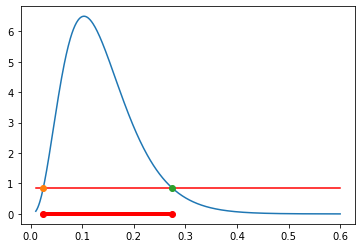

In [3]:
# figure 1

# unlike MATLAB i:j:k syntax, arange is not inclusive at the high end
xx = np.arange(0.01, 0.601, 0.001)
a = 4
b = 29

# curve
plt.plot(xx, gamma_pdf(xx, a, b))

# additional markings
plt.plot(xx, np.full_like(xx, 0.857), "r-")
plt.plot(0.0246, gamma_pdf(0.0246, a, b), "o")
plt.plot(0.0246, 0, "ro")
plt.plot(0.2741, gamma_pdf(0.2741, a, b), "o")
plt.plot(0.2741, 0, "ro")
plt.plot([0.0246, 0.2741], [0, 0], "r-", linewidth=4)
plt.show()

In [4]:
# hpd credible set

k = 0.857368863848

lower_hpd = fsolve(lambda x: gamma_pdf(x, a, b) - k, 0.05)[0]
upper_hpd = fsolve(lambda x: gamma_pdf(x, a, b) - k, 0.4)[0]
print(f"HPD credible set: [{lower_hpd} {upper_hpd}]")

prob_hpd = gamma.cdf(upper_hpd, a, scale=1 / b) - gamma.cdf(lower_hpd, a, scale=1 / b)
print(f"Probability within hpd bounds: {prob_hpd}")
print(f"length of hpd cs: {upper_hpd - lower_hpd}")

HPD credible set: [0.024568994513107345 0.27407917790064784]
Probability within hpd bounds: 0.9500000000000202
length of hpd cs: 0.2495101833875405


In [5]:
# equi-tailed credible set

# percent point function aka inverse cdf
lower_eqt = gamma.ppf(0.025, a, scale=1 / b)
upper_eqt = gamma.ppf(0.975, a, scale=1 / b)
print(f"Equitailed credible set: [{lower_eqt} {upper_eqt}]")

prob_eqt = gamma.cdf(upper_eqt, a, scale=1 / b) - gamma.cdf(lower_eqt, a, scale=1 / b)
print(f"Probability within eqt bounds: {prob_eqt}")
print(f"length of eqt cs: {upper_eqt - lower_eqt}")

Equitailed credible set: [0.037581564607804305 0.3023197610255974]
Probability within eqt bounds: 0.95
length of eqt cs: 0.26473819641779306


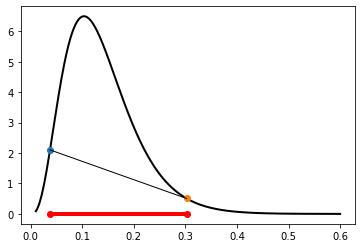

In [6]:
# figure 2

# curve
plt.plot(xx, gamma_pdf(xx, a, b), "k-", linewidth=2)

plt.plot(lower_eqt, gamma_pdf(lower_eqt, a, b), "o")
plt.plot(lower_eqt, 0, "ro")
plt.plot(upper_eqt, gamma_pdf(upper_eqt, a, b), "o")
plt.plot(upper_eqt, 0, "ro")
plt.plot([lower_eqt, upper_eqt], [0, 0], "r-", linewidth=4)
plt.plot(
    [lower_eqt, upper_eqt],
    [gamma_pdf(lower_eqt, a, b), gamma_pdf(upper_eqt, a, b)],
    "k-",
    linewidth=1,
)
plt.show()

Right now I want to get through these examples so Spring 2022 students can get some use out of them. Later on, I think this example could use a lot more explanation and expansion.

## Find the HPD credible interval when you don't know k

A student in the Spring 2022 class was wondering where the .05 and .4 values entered to ```fsolve()``` came from. They're just your guesses for the lower and upper bounds of the credible interval. They give the optimizer a starting point.

That led to the bigger question of where $k$ came from. What you need to find is the output of $k(α)$, which is a horizontal line that intersects the posterior PDF at the lower and upper bounds of your HPD credible interval. The reason we want a horizontal line is that this ensures that you've got the shortest interval covering credibility $1 - α$ (we usually choose a credibility of .95 in this course, but that's arbitrary).

I don't know how the professor did it originally, but here are two methods to estimate the HPD interval. Both assume that the posterior is unimodal, but could be extended to account for multimodal cases.

### Optimization method
First, an optimization method, pretty much just trying lots of values for $k$ (guessing Professor Vidakovic did it this way):

1. Loop over a bunch of possible k values, each time using an equation like fzero() on the pdf of your posterior minus k. This will solve for the location that your pdf intersects with k. You need to feed the optimizer an initial guess, one lower, near the lower bound of the credible interval, and one higher, near the upper bound.

2. Enter each bound into the posterior CDF, subtract the results to get the probability the posterior falls within those bounds. If it's close enough to 1 - α, you can stop the loop because you have your answer. If not, the loop continues.

In [7]:
# Finding the HPD credible set

# our pdf is Gamma(4, 1/29) where 29 is the rate.
# looking at the plot, k must be between 0-2

a = 4
b = 29
alpha = 0.05
tolerance = 0.0001
iterations = 20000

# initial guesses
guess_lwr = 0.05
guess_upr = 0.4
possible_k = np.linspace(0, 2, iterations)

# if loop finishes without printing anthing, no solution within given tolerance
# solution: adjust tolerance, initial guesses, range of possible_k
for k in tqdm(possible_k):
    lower = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_lwr)[0]
    upper = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_upr)[0]
    prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)
    if abs(prob - (1 - alpha)) <= tolerance:
        print(f"{k=}")
        print(f"HPD credible set: {lower, upper}")
        print(f"length = {upper - lower}")
        print(f"probability within these bounds: {prob}")
        break

  0%|          | 0/20000 [00:00<?, ?it/s]

/Users/aaron/mambaforge/envs/pymc3_test/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


k=0.855942797139857
HPD credible set: (0.02455112335043536, 0.2741713733854568)
length = 0.24962025003502142
probability within these bounds: 0.950094289217813


This method is really finicky, you might find yourself needing to adjust the tolerance and initial guesses quite a bit. It helps to base your guesses off visual inspection of a plot of the posterior.

### Sampling method

There's another way that I find simpler, which involves sampling lots of values from the posterior. This is also the way it's generally done in practice (see the source code for hpd or hdi functions in many Bayesian libraries like [Arviz](https://arviz-devs.github.io/arviz/_modules/arviz/stats/stats.html#hdi) or [MCMCChains.jl](https://github.com/TuringLang/MCMCChains.jl/blob/master/src/stats.jl)). This method is simplified - it won't work for as many different cases as the ones in those packages, but it's easier to understand.

1. Draw some samples from your posterior.
2. Sort them from smallest to largest.
3. Compute the possible credible intervals.
4. Take the one with the minimum width.

See [Chen and Shao, 1999](https://www.jstor.org/stable/1390921) for the math.

In [8]:
def calc_hdi(samples: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Calculate minimum-width credible interval (HPD credible set)

    samples: samples from posterior
    alpha: credibility of the interval = 1 - alpha

    returns tuple of the lower and upper bounds of the interval
    """
    n = len(samples)
    x = np.sort(samples)

    lower_idx = int(np.floor(alpha * n))
    x_left = x[:lower_idx]
    x_right = x[n - lower_idx :]

    idx = np.argmin(x_right - x_left)

    upper_bound = x_right[idx]
    lower_bound = x_left[idx]

    return lower_bound, upper_bound


a = 4
b = 29

samples = gamma.rvs(a, scale=1 / b, size=1000000)
lower, upper = calc_hdi(samples, alpha=0.05)
# double-check credibility
prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)

print(f"HPD credible set: {lower, upper}")
print(f"length = {upper - lower}")
print(f"probability within these bounds: {prob}")

HPD credible set: (0.02452192943787325, 0.27414937182449606)
length = 0.24962744238662282
probability within these bounds: 0.9501004077382441


In [3]:
# use np.quantile for equitailed credible sets

a = 4
b = 29
n = 1000000
samples = gamma.rvs(a, scale=1 / b, size=n)

x = np.sort(samples)
alpha = .05

lower_idx = int(np.floor(alpha / 2 * n))
upper_idx = int(np.floor((1 - alpha / 2) * n))
                
print(f"manual = {x[lower_idx], x[upper_idx]}")

np.quantile(samples, (.025, .975))
                

manual = (0.037617300662171664, 0.30254030604637866)


array([0.0376173 , 0.30253363])